In [ ]:
# To be sure that if you modify a .py file everything is up to date

%load_ext autoreload
%autoreload 2

## Exercise 1

* create a dataloader to load the galaxy10 dataset
* build a classifier with a fully connceted neural network
* write a function to compute the classification accuracy of the network prediction
* write a training loop and train the model
* save the loss and accuracy for both the training dataset and the validation dataset after every epoch
* plot the loss and accuracy
* save the trained model and the dataset / model in a source code (in a .py file)

<b> You have to build a classifier for the galaxy10 dataset. Given a galaxy you have to say which class it belongs to. </b>

In [1]:
!unzip ../Datasets/Dataset_galaxies.zip

'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [1]:
# The dataset is already divided in training and validation

path_to_training_data = 'Dataset/train/'
path_to_validation_data = 'Dataset/validation/'

### Dataset

The first part of your exercise is to take the following lines and added to the dataloader.py file (in the correct position).

In [2]:
#First we get a list of the files in the directory

import glob

# Glob gives you a list of file paths to the images
filelist = glob.glob(path_to_training_data+'/*.png')

# Print the first 10 entries:
filelist[:10]

['Dataset/train\\class0_1023.png',
 'Dataset/train\\class0_1039.png',
 'Dataset/train\\class0_1043.png',
 'Dataset/train\\class0_1048.png',
 'Dataset/train\\class0_1051.png',
 'Dataset/train\\class0_1058.png',
 'Dataset/train\\class0_1065.png',
 'Dataset/train\\class0_1068.png',
 'Dataset/train\\class0_1073.png',
 'Dataset/train\\class0_1074.png']

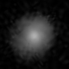

In [3]:
# To load a single image, use the PIL (python image library) function Image
from PIL import Image

Image.open(filelist[0])

In [4]:
# We want to turn it into a pytorch tensor, 
# And flatten it (since we want to train a fully connceted network)
from torchvision import datasets, transforms

img = Image.open(filelist[0])

transforms.ToTensor()( img ).view(-1).shape



torch.Size([4761])

In [5]:
## We want to normalize our inputs, to have mean pixel value of 0 and standard deviation 1
import numpy as np

lots_of_images = np.concatenate( [transforms.ToTensor()(Image.open(x)).view(-1) for x in filelist[:1000]] )
print(np.mean(lots_of_images),np.std(lots_of_images))

0.085366935 0.120706186


In [31]:
# To determine the class label of an image, just look at its name:

filelist[:5]

['Dataset/train\\class0_1023.png',
 'Dataset/train\\class0_1039.png',
 'Dataset/train\\class0_1043.png',
 'Dataset/train\\class0_1048.png',
 'Dataset/train\\class0_1051.png']

In [8]:
# We generate numerical labels based on the file name
# For each element in the filelist it returns the labels

import torch

labels = np.zeros(len(filelist))

for class_i in range(10):
    labels[ np.array(['class'+str(class_i) in x for x in filelist]) ] = class_i
    
# The labels need to be converted to torch.LongTensor for multi-class classification
# See the documentation at https://pytorch.org/docs/stable/nn.html#crossentropyloss
labels = torch.LongTensor(labels)

labels

tensor([0, 0, 0,  ..., 9, 9, 9])

You should get something that works now...

In [6]:
from dataloader import CustomDataset

# If it doesn't work, I suggest you writing the class here 
# afterwords copy it in the dataloader.py

In [70]:
from torch.utils.data import Dataset, DataLoader
import torch
import numpy as np
from torchvision import datasets, transforms
from PIL import Image
import glob

class CustomDataset(Dataset):
    def __init__(self, path, n_classes=10, transform = False):
        
        self.transform = transform
        self.filelist = glob.glob(path+'/*.png')
        labels = np.zeros(len(self.filelist))
        for class_i in range(10):
            labels[ np.array(['class'+str(class_i) in x for x in self.filelist]) ] = class_i
            
        self.labels = torch.LongTensor(labels)  #... load the labels (copy from the notebook)
        
    def __len__(self):
       
        return len(self.filelist)

    def __getitem__(self, idx):
        
        img = Image.open(self.filelist[idx])
        
        x = transforms.ToTensor()( img ).view(-1) #.... transform to tensor and flatten it to a tensor of 69*69 = 4761
        
        y = self.labels[idx]
    
        return x, y

In [71]:
training_ds = CustomDataset(path_to_training_data,transform=True)
validation_ds = CustomDataset(path_to_validation_data)

some_random_idx = 124
training_ds[some_random_idx]

(tensor([0.0118, 0.0235, 0.0118,  ..., 0.0157, 0.0118, 0.0235]), tensor(0))

In [72]:
## lets also go ahead and create the data loaders (already a pytorch function),
## and set the batch size

training_dataloader = DataLoader(training_ds, batch_size = 300, shuffle = True) # random batches
valid_dataloader = DataLoader(validation_ds, batch_size = 300)

# x should be (batchsize, 69*69) = (300,4761)
# y should be (batchsize) = (300)

for x,y in training_dataloader:
    print(x.shape,y.shape)
    break

torch.Size([300, 4761]) torch.Size([300])


### Examples

This should work if dataset and dataloader are set correctly

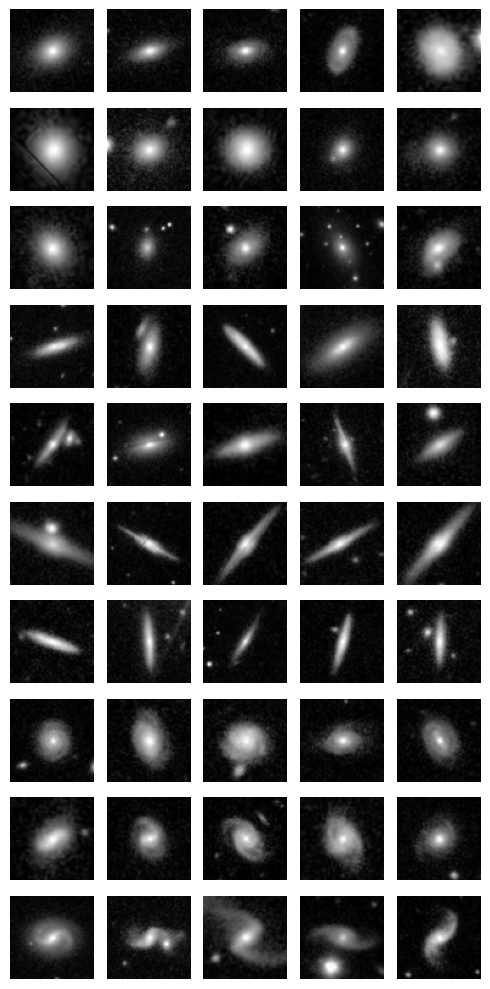

In [23]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots(10,5,figsize=(5,10))

for class_i in range(10):
    idxs = np.where( training_ds.labels == class_i )[0]
    idxs = np.random.permutation(idxs)
    for plot_i in range(np.min([5,len(idxs)])):

        ax[class_i][plot_i].imshow(training_ds[idxs[plot_i]][0].reshape(69,69),cmap='gray')
        ax[class_i][plot_i].set_axis_off()
        
plt.tight_layout()
plt.show()

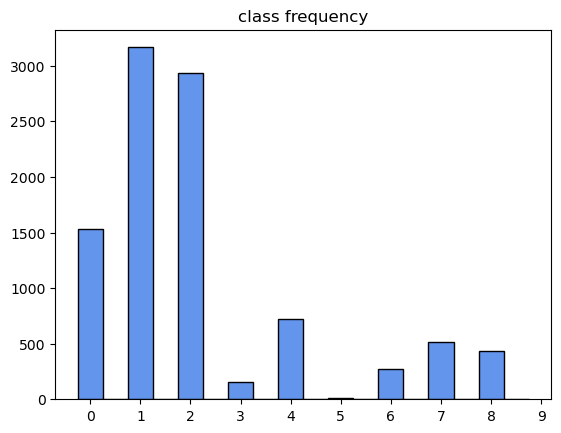

In [74]:
# checking the labels

plt.hist(training_ds.labels.data,bins=np.linspace(0,9,19)-0.25,color='cornflowerblue',ec='k')
plt.xticks(np.arange(10))
plt.title('class frequency')
plt.show()

### The model

It's a classifier, it takes a 69 * 69 numbers, and outputs 10 numbers.

In [75]:
from model import Net

# create the istance
net = Net()
print(net)

Net(
  (layer1): Linear(in_features=4761, out_features=256, bias=True)
  (relu1): ReLU()
  (layer2): Linear(in_features=256, out_features=128, bias=True)
  (relu2): ReLU()
  (layer3): Linear(in_features=128, out_features=64, bias=True)
  (relu3): ReLU()
  (layer4): Linear(in_features=64, out_features=10, bias=True)
)


In [76]:
# Try it... it shoule be (batch size, 10) = (300, 10)

for x,y in training_dataloader:
    break

net(x).shape

torch.Size([300, 10])

In [77]:
# It will be usefull for future exercises, it check if you have cuda. 
# CUDA is a parallel computing platform and programming model that makes using a GPU for general purpose computing simple
# maybe start reading about google colab, it's free and will be useful later

if torch.cuda.is_available():
    net.cuda()


### Loss and accuracy

We want to create a function that will compute the loss and accuracy at the end of each epoch

In [78]:
import torch.nn as nn


In [79]:
import torch.optim as optim

loss_func = nn.CrossEntropyLoss()
#It is useful when training a classification problem with C classes. 
#If provided, the optional argument weight should be a 1D Tensor assigning weight to each of the classes.
optimizer = optim.Adam(net.parameters(), lr = 0.001) 

In [83]:
def compute_accuracy_and_loss(dataloader,net):
    total = 0
    correct = 0
    loss = 0
    
    if torch.cuda.is_available():
        net.cuda()
        
    net.eval() # When you want to compute loss or accuracy you always have to put the netowrk in evaluation mode
    
    n_batches = 0
    
    with torch.no_grad():
        for x,y in dataloader:
            n_batches += 1

            
            if torch.cuda.is_available():
                x = x.cuda()
                y = y.cuda()
                
            pred = net(x)
            loss += loss_func(pred,y).item()
            pred = torch.argmax(pred,dim=1)

            correct += len(torch.where(pred==y)[0])
            total += len(y)
            
    loss = loss/n_batches      
    return correct/total, loss



In [84]:
# Check the accuracy before training, it should be low
compute_accuracy_and_loss(training_dataloader,net)

(0.1537, 2.2929211854934692)

### Training

* Optimizer zero gradient
* Output from the network
* Computing loss function between output and y
* Loss backward
* Optimizer step 

In [87]:
from tqdm.notebook import tqdm

n_epochs = 50

training_loss_vs_epoch = []
validation_loss_vs_epoch = []

training_acc_vs_epoch = []
validation_acc_vs_epoch = []

pbar = tqdm( range(n_epochs) )

for epoch in pbar:
    
    if len(validation_loss_vs_epoch) > 1:
        pbar.set_description('val acc:'+'{0:.5f}'.format(validation_acc_vs_epoch[-1])+
                             ', train acc:'+'{0:.5f}'.format(training_acc_vs_epoch[-1]))
    
    net.train() # put the net into "training mode"
    
    for x,y in training_dataloader:
        
        if torch.cuda.is_available():
            x = x.cuda()
            y = y.cuda()
            
        optimizer.zero_grad()

        # compute output of the newtork
        output = net(x)
        # compute the loss function
        # loss = loss_func...
        loss = loss_func(output,y)
        loss.backward()
        optimizer.step()
    
    net.eval() #put the net into evaluation mode
    
    train_acc, train_loss = compute_accuracy_and_loss(training_dataloader,net)
    valid_acc, valid_loss = compute_accuracy_and_loss(valid_dataloader,net)
         
    training_loss_vs_epoch.append( train_loss)    
    training_acc_vs_epoch.append( train_acc )
    
    validation_acc_vs_epoch.append(valid_acc)
    validation_loss_vs_epoch.append(valid_loss)
    
    # It saves the model if the validation loss has decreased
    if len(validation_loss_vs_epoch)==1 or validation_loss_vs_epoch[-2] > validation_loss_vs_epoch[-1]:
        torch.save(net.state_dict(), 'trained_model.pt')

  0%|          | 0/50 [00:00<?, ?it/s]

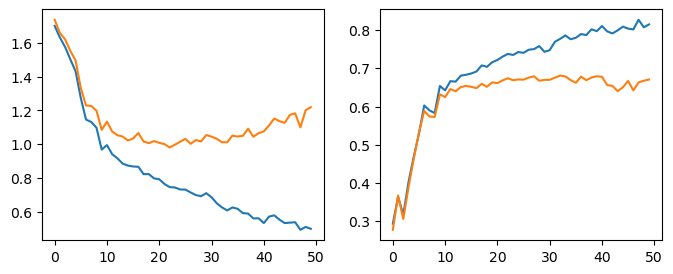

In [88]:
fig,ax = plt.subplots(1,2,figsize=(8,3))

ax[0].plot(training_loss_vs_epoch,label='training')
ax[0].plot(validation_loss_vs_epoch,label='validation')

ax[1].plot(training_acc_vs_epoch)
ax[1].plot(validation_acc_vs_epoch)

plt.show()

### Bonus part

As you so the result is not so exciting, a lot of overtraining.

Try to rewrite the dataloader in a way that every image gets a random rotation. Then, retrain the network. Hopefully you will get a better result. Do you know why????

In [89]:
img = Image.open(self.filelist[443])
img

NameError: name 'self' is not defined

In [ ]:
transforms.RandomRotation(img)